# 0. Libraries

In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt

import sys
import os
import requests
import tarfile
import pickle

Using TensorFlow backend.


# 1. Download and process data

In [2]:
def download_data(url, filename):
    url_data = requests.get(url, stream=True)
    file_size_bytes = int(url_data.headers['content-length'])
    downloaded_size_bytes = 0
    with open(filename, "wb") as f:
            for data in url_data.iter_content(chunk_size=10240):
                f.write(data)
                downloaded_size_bytes += len(data)
                downloaded_proc = 100 * downloaded_size_bytes / file_size_bytes
                sys.stdout.write("\r%d/%d bytes downloaded, %.1f" % 
                                 (downloaded_size_bytes, file_size_bytes, downloaded_proc) + '% done')
                sys.stdout.flush()
    return
                
def untar(filename, folder):
    tar = tarfile.open(filename)
    tar.extractall(folder)
    tar.close()
    return
                
def unpickle(filename):
    with open(filename, 'rb') as f:
        data_dict = pickle.load(f, encoding='bytes')
        data_dict_decoded = {}
        for key, value in data_dict.items():
            data_dict_decoded[key.decode('utf8')] = value
        data_dict = data_dict_decoded
    return data_dict

def load_batch(filename):
    data_dict = unpickle(filename)
    data = data_dict['data']
    labels = data_dict['labels']
    data = data.reshape(data.shape[0], 3, 32, 32)
    data = data.transpose(0, 2, 3, 1) #channels in tensorflow are last
    return data, labels

def load_data(folder):
    X_train = np.empty((50000, 32, 32, 3), dtype='uint8')
    y_train = np.empty((50000,), dtype='uint8')
    for i in np.arange(5):
        filename = os.path.join(folder, 'data_batch_' + str(i + 1))
        (X_train[i * 10000 : (i + 1) * 10000, :, :, :], y_train[i * 10000 : (i + 1) * 10000]) = load_batch(filename)
    filename = os.path.join(folder, 'test_batch')
    X_test, y_test = load_batch(filename)
    # y_train = np.reshape(y_train, (len(y_train), 1))
    # y_test = np.reshape(y_test, (len(y_test), 1))
    return X_train, y_train, X_test, y_test

In [3]:
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filename = './data/cifar-10-python.tar.gz'

In [4]:
if not os.path.exists('./data'):
    os.makedirs('./data')
download_data(url, filename)

In [5]:
untar(filename, 'data')

In [6]:
folder = './data/cifar-10-batches-py/'
X_train, y_train, X_test, y_test = load_data(folder)

In [8]:
# # If it was allowed, we could download and load data with 2 lines:
# from keras.datasets import cifar10
# (X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [9]:
import collections
collections.Counter(y_train), collections.Counter(y_test)

(Counter({6: 5000,
          9: 5000,
          4: 5000,
          1: 5000,
          2: 5000,
          7: 5000,
          8: 5000,
          3: 5000,
          5: 5000,
          0: 5000}),
 Counter({3: 1000,
          8: 1000,
          0: 1000,
          6: 1000,
          1: 1000,
          9: 1000,
          5: 1000,
          7: 1000,
          4: 1000,
          2: 1000}))

# 2. 10 random images from each class

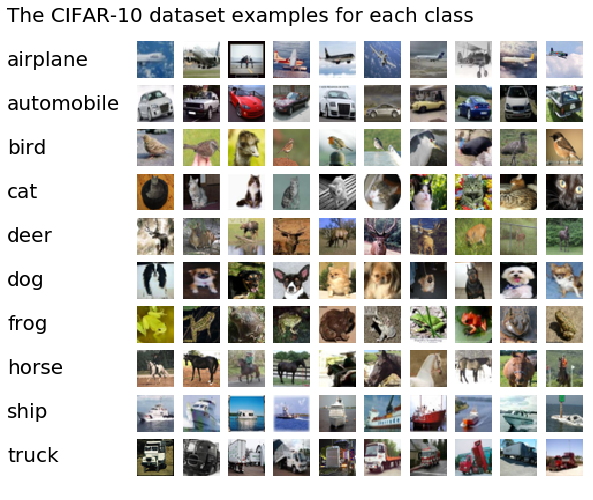

In [10]:
fig, axes = plt.subplots(10, 10, figsize=(8, 8))
for i in np.unique(y_train):
    for j in np.arange(10):
        k = np.random.choice(np.where(y_train == i)[0])
        axes[i, j].set_axis_off()
        axes[i, j].imshow(X_train[k])
fig.suptitle('The CIFAR-10 dataset examples for each class\n\nairplane\n\nautomobile' + 
             '\n\nbird\n\ncat\n\ndeer\n\ndog\n\nfrog\n\nhorse\n\nship\n\ntruck', 
             x=-0.1, y=0.94, horizontalalignment='left', fontsize=20)
plt.show()

# 3. Shallow classifier

In [11]:
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import time

def extract_feature(image, visualize=False):
    return hog(image, 
               orientations=9, 
               pixels_per_cell=(8, 8),
               cells_per_block=(2, 2),
               block_norm='L2-Hys',
               visualize=visualize,
               multichannel=True)

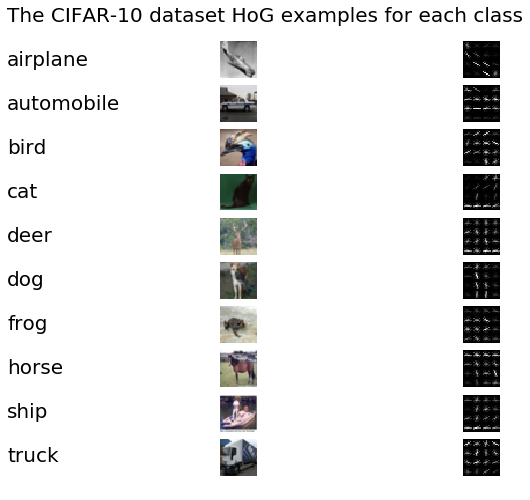

In [12]:
fig, axes = plt.subplots(10, 2, figsize=(8, 8))
for i in np.unique(y_train):
    k = np.random.choice(np.where(y_train == i)[0])
    axes[i, 0].set_axis_off()
    axes[i, 0].imshow(X_train[k])
    axes[i, 1].set_axis_off()
    fd, hog_image = extract_feature(X_train[k], visualize=True)
    axes[i, 1].imshow(hog_image, cmap='gray')
fig.suptitle('The CIFAR-10 dataset HoG examples for each class\n\nairplane\n\nautomobile' + 
             '\n\nbird\n\ncat\n\ndeer\n\ndog\n\nfrog\n\nhorse\n\nship\n\ntruck', 
             x=-0.1, y=0.94, horizontalalignment='left', fontsize=20)
plt.show()

In [13]:
X_train_hog = np.array([extract_feature(image).tolist() for image in X_train])
X_test_hog = np.array([extract_feature(image).tolist() for image in X_test])

In [14]:
for C in [0.01, 0.1, 1, 10]:
    start_time = time.time()
    svc = SVC(C=C, kernel="linear")
    svc.fit(X_train_hog, y_train)
    y_pred = svc.predict(X_test_hog)
    accuracy = accuracy_score(y_test, y_pred)
    computation_time = time.time() - start_time
    print('SVC(C={}, kernel="linear"): accuracy_score = {}, computation_time = {:.2f}min.'.format(C, accuracy, 
                                                                                          computation_time / 60))

SVC(C=0.01, kernel="linear"): accuracy_score = 0.5066, computation_time = 19.61min.
SVC(C=0.1, kernel="linear"): accuracy_score = 0.5325, computation_time = 14.53min.
SVC(C=1, kernel="linear"): accuracy_score = 0.5409, computation_time = 13.65min.
SVC(C=10, kernel="linear"): accuracy_score = 0.5421, computation_time = 24.53min.


Results:

SVC(C=0.01, kernel="linear"): accuracy_score = 0.5066, computation_time = 19.61min.  
SVC(C=0.1, kernel="linear"): accuracy_score = 0.5325, computation_time = 14.53min.  
SVC(C=1, kernel="linear"): accuracy_score = 0.5409, computation_time = 13.65min.  
SVC(C=10, kernel="linear"): accuracy_score = 0.5421, computation_time = 24.53min.  

# 4. Visual features from pre-trained CNN network

In [15]:
from keras.models import Model
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.layers import Input, AveragePooling2D, MaxPooling2D
import cv2

def extract_visual_features(model, data, batch_size=32):
    visual_features = np.zeros((data.shape[0], model.output.shape.as_list()[3]))
    nb_batches = np.ceil(data.shape[0] / batch_size)
    for i in np.arange(nb_batches):
        start = int(batch_size * i)
        end = int(batch_size * (i + 1)) if batch_size * (i + 1) < data.shape[0] else int(data.shape[0])
        batch = np.zeros((end - start, 224, 224, 3))
        for j, image in enumerate(data[start:end]):
            resized_image = cv2.resize(image, dsize=(224, 224))
            batch[j] = resized_image
        batch = preprocess_input(batch)
        batch_predict = model.predict(batch)
        visual_features[start:end] = [feature.flatten() for feature in batch_predict]
        sys.stdout.write("\r%d/%d batches, %.1f" % 
                         (i + 1, nb_batches, 100 * (i + 1) / nb_batches) + '% done')
        sys.stdout.flush()
    return visual_features

In [16]:
model_input = Input(shape=(224, 224, 3))
model_vgg19 = VGG19(input_tensor=model_input, include_top=False)
model_output = AveragePooling2D((7, 7))(model_vgg19.output)
model = Model(model_vgg19.input, model_output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [18]:
X_train_visual_features = extract_visual_features(model, X_train)

1563/1563 batches, 100.0% done

In [19]:
X_test_visual_features = extract_visual_features(model, X_test)

313/313 batches, 100.0% done

In [20]:
X_train_visual_features.shape, X_test_visual_features.shape

((50000, 512), (10000, 512))

In [21]:
np.save('./data/X_train_visual_features_vgg19.npy', X_train_visual_features)
np.save('./data/X_test_visual_features_vgg19.npy', X_test_visual_features)

# 5. The CNN Codes visualisation

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [23]:
folder = './data/cifar-10-batches-py/'
X_train, y_train, X_test, y_test = load_data(folder)
X_train_visual_features = np.load('./data/X_train_visual_features_vgg19.npy')
X_test_visual_features = np.load('./data/X_test_visual_features_vgg19.npy')

In [24]:
scaler = StandardScaler()
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(scaler.fit_transform(X_train_visual_features))

In [25]:
pca.explained_variance_ratio_

array([0.07267572, 0.05702655])

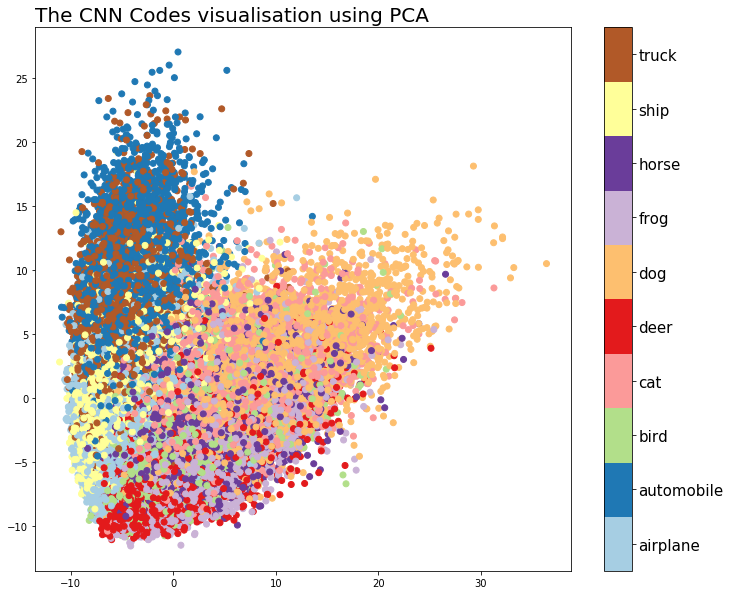

In [26]:
plt.figure(figsize=(12, 10))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.get_cmap('Paired', 10),
               vmin=-0.5, vmax=9.5)
colorbar = plt.colorbar(ticks=np.arange(0,10))
colorbar.ax.set_yticklabels(['airplane', 'automobile', 'bird', 'cat', 'deer',
                             'dog', 'frog', 'horse', 'ship', 'truck'], fontsize=15)
plt.title('The CNN Codes visualisation using PCA', loc='left', fontsize=20)
plt.show()

# 6. SVM classifier on top of the CNN Codes

# 7. Evaluation of final model on the test set

# 8. Bonus task